<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression:" data-toc-modified-id="LinearRegression:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression:</a></span></li><li><span><a href="#RandomForestRegressor:" data-toc-modified-id="RandomForestRegressor:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor:</a></span></li><li><span><a href="#CatBoostRegressor:" data-toc-modified-id="CatBoostRegressor:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

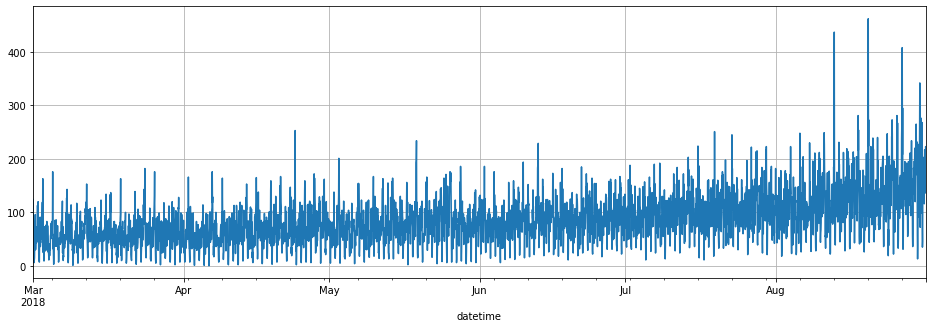

In [4]:
ax = data['num_orders'].plot(figsize=(16,5), grid=True)

Наблюдается довольно сильная автокорреляция с периодами 24 часа (суточная) и 168 часов (недельная):

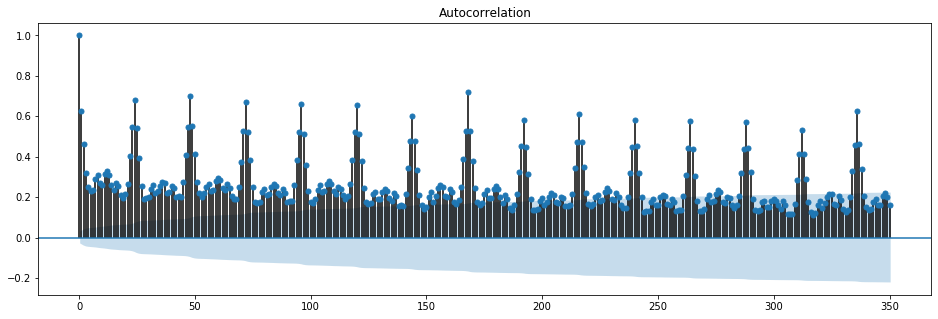

In [5]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot()
fig = plot_acf(data['num_orders'], lags=350, ax=ax)


In [6]:
test = adfuller(data['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.068924289027949
p-value:  0.02894005140261345
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


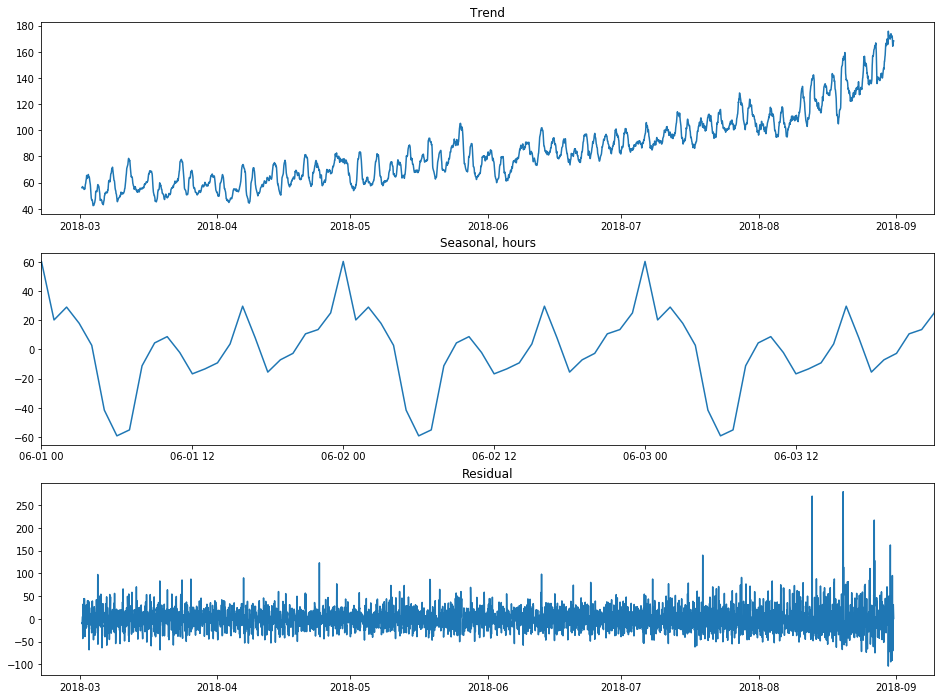

In [7]:
decomposed = seasonal_decompose(data['num_orders'])

fig, axs = plt.subplots(3, figsize=(16,12), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal)
axs[1].set_title("Seasonal, hours")
# Fixed:
axs[1].set_xlim(left = pd.to_datetime('2018-07-20 00:00'),
               right = pd.to_datetime('2018-07-23 00:00'))


axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

## Обучение

Подготовим признаки:

In [8]:
data['an_hour_ago'] = data['num_orders'].shift()
data['a_day_ago'] = data['num_orders'].shift(24)
data['a_week_ago'] = data['num_orders'].shift(24*7)
data['a_fortnight_ago'] = data['num_orders'].shift(24*14)
data['moving_average'] = data['num_orders'].shift().rolling(24*5).mean()
data['day'] = data.index.day
data = data.dropna()
data

,num_orders,an_hour_ago,a_day_ago,a_week_ago,a_fortnight_ago,moving_average,day
datetime,,,,,,,
2018-03-15 00:00:00,123,65.0,84.0,143.0,124.0,59.466667,15
2018-03-15 01:00:00,85,123.0,72.0,78.0,85.0,59.516667,15
2018-03-15 02:00:00,55,85.0,39.0,65.0,71.0,59.575000,15
2018-03-15 03:00:00,42,55.0,57.0,68.0,66.0,59.833333,15
2018-03-15 04:00:00,15,42.0,21.0,60.0,43.0,59.816667,15
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.0,72.0,113.0,84.0,158.533333,31
2018-08-31 20:00:00,154,136.0,142.0,179.0,126.0,158.616667,31
2018-08-31 21:00:00,159,154.0,198.0,166.0,144.0,158.883333,31


Выделим тестовую выборку 10% и разделим признаки и цель:

In [9]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

trainX = train.drop('num_orders', axis=1)
trainY = train['num_orders']

testX = test.drop('num_orders', axis=1)
testY = test['num_orders']

### LinearRegression:

In [10]:
%%time
lr = LinearRegression()
lr.fit(trainX, trainY)

print("RMSE обучающей выборки:", mean_squared_error(trainY, lr.predict(trainX))**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(testY, lr.predict(testX))**0.5)

RMSE обучающей выборки: 21.876732900557002
RMSE тестовой выборки:  33.81487972808937
CPU times: user 39.8 ms, sys: 57.1 ms, total: 96.8 ms
Wall time: 124 ms


### RandomForestRegressor:

In [11]:
%%time
rf = RandomForestRegressor(n_estimators=20, random_state=123)
rf.fit(trainX, trainY)

print("RMSE обучающей выборки:", mean_squared_error(trainY, rf.predict(trainX))**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(testY, rf.predict(testX))**0.5)

RMSE обучающей выборки: 9.12145676873371
RMSE тестовой выборки:  38.82346475317699
CPU times: user 242 ms, sys: 1.23 ms, total: 243 ms
Wall time: 242 ms


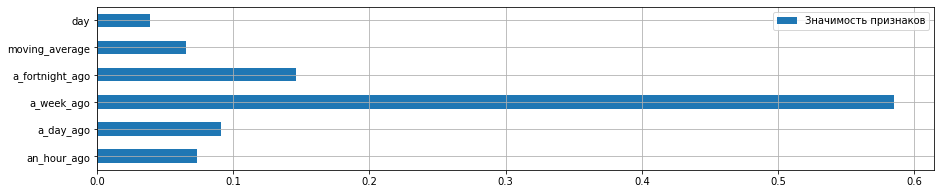

In [12]:
ax = pd.DataFrame(rf.feature_importances_, 
                  columns=['Значимость признаков'], 
                  index=trainX.columns).plot(kind='barh', grid=True, figsize=(15,3))

### CatBoostRegressor:

In [13]:
%%time 
cb = CatBoostRegressor(loss_function='RMSE', iterations=20, depth=4, learning_rate=0.5) 
cb.fit(trainX, trainY, verbose=5)
print()
print("RMSE обучающей выборки:", mean_squared_error(trainY, cb.predict(trainX))**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(testY, cb.predict(testX))**0.5)
print()

0:	learn: 29.5511852	total: 48.2ms	remaining: 917ms
5:	learn: 22.2154271	total: 52.6ms	remaining: 123ms
10:	learn: 21.5999811	total: 58ms	remaining: 47.4ms
15:	learn: 21.3329113	total: 137ms	remaining: 34.1ms
19:	learn: 21.0017672	total: 222ms	remaining: 0us

RMSE обучающей выборки: 21.001767196571976
RMSE тестовой выборки:  37.59015808960824

CPU times: user 207 ms, sys: 63.5 ms, total: 271 ms
Wall time: 1.24 s


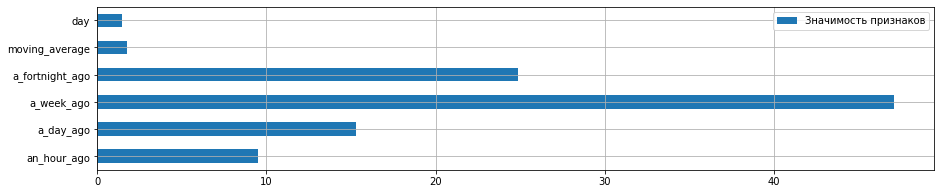

In [14]:
ax = pd.DataFrame(cb.feature_importances_, 
                  columns=['Значимость признаков'], 
                  index=trainX.columns).plot(kind='barh', grid=True, figsize=(15,3))

## Тестирование

__Визуализируем предсказания различными моделями в течении одной произвольной недели:__

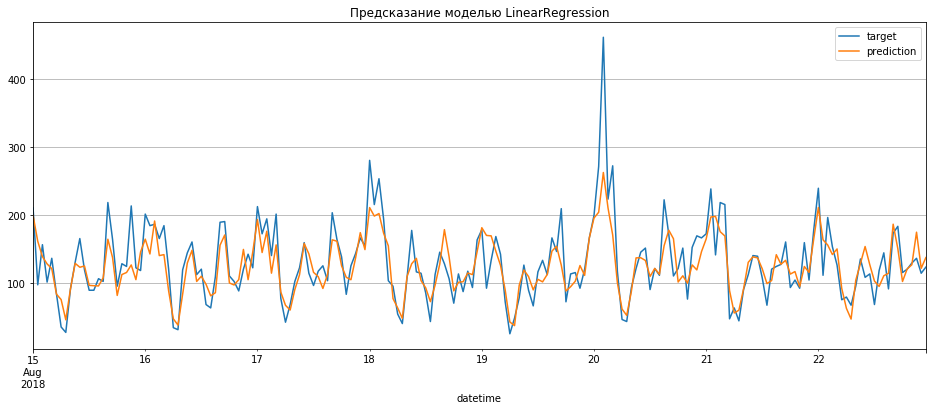

In [15]:
test_week = pd.DataFrame()
test_week['target'] = data['2018-08-15':'2018-08-22']['num_orders']
test_week['prediction'] = lr.predict(data['2018-08-15':'2018-08-22'].iloc[:,1:])
ax = test_week.plot(figsize=(16,6), grid=True, title='Предсказание моделью LinearRegression')

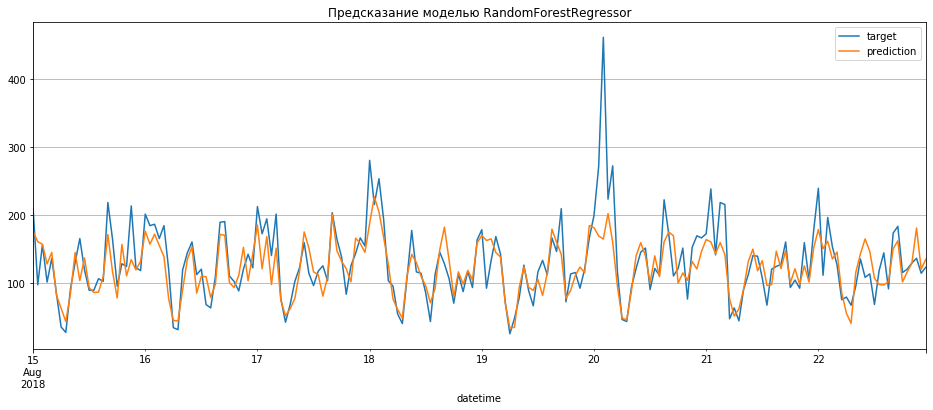

In [16]:
test_week = pd.DataFrame()
test_week['target'] = data['2018-08-15':'2018-08-22']['num_orders']
test_week['prediction'] = rf.predict(data['2018-08-15':'2018-08-22'].iloc[:,1:])
ax = test_week.plot(figsize=(16,6), grid=True, title='Предсказание моделью RandomForestRegressor')

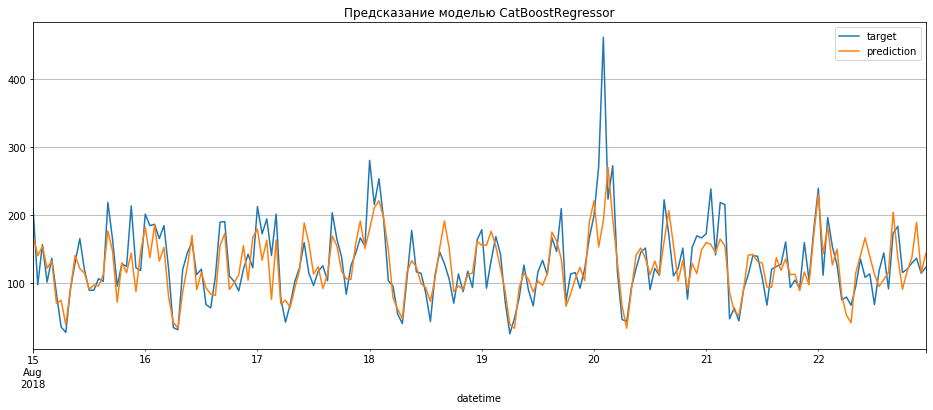

In [17]:
test_week = pd.DataFrame()
test_week['target'] = data['2018-08-15':'2018-08-22']['num_orders']
test_week['prediction'] = cb.predict(data['2018-08-15':'2018-08-22'].iloc[:,1:])
ax = test_week.plot(figsize=(16,6), grid=True, title='Предсказание моделью CatBoostRegressor')

## Общий вывод:

- В данном проекте наилучший результат продемонстрировала модель LinearRegression  
показав результат RMSE=33.81  на тестовой выборке (требовалось не более 48). 
- Кроме того, эта модель наименее ресурсоемкая.  
- Для предсказания количества заказов на следующий час   
требуется информация за предыдущие 2 недели, ресэмплированная с периодом 1 час.
